Attila Cangi, 14.02.2020

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import integrate
from scipy import interpolate
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Parameters

In [2]:
# Temperature
temp = 298

# Fermi Level
fermi_energy = 7.770345

# Boltzmann's constant
k = 8.617333262145e-5

# Conversion factor from Rydberg to eV
Ry2eV = 13.6056980659

# Gaussian smearing in QE-DOS calculations
# taken from QE-DOS input file
sigma_qe = 0.032

Load eigenvalues and DOS from QE output

In [3]:
# filepath: blake.sandia.gov:/home/acangi/q-e_calcs/Al/datasets/vasp_econ_snapshots/298K/2.699g/170726180545.0/100Ry_k333
## Snapshot 0: Eigenvalues (from PW std output file, slurm-1006575.out)
### rows: band index, row i: eigs[i , :]
### cols: k points,   col j: eigs[: , j]
eigs_qe = np.loadtxt('snap_0/EIGS', delimiter=',')
k_weights_qe = np.loadtxt('snap_0/k_weights', delimiter=',')
## DOS
dos_qe = np.loadtxt('snap_0/Al.dos', skiprows=1)
## Snapshot 1: Eigenvalues (from PW std output file, slurm-1006846.out)
### rows: band index, row i: eigs[i , :]
### cols: k points,   col j: eigs[: , j]
eigs_qe_01 = np.loadtxt('snap_1/EIGS', delimiter=',')
k_weights_qe_01 = np.loadtxt('snap_1/k_weights', delimiter=',')
## DOS
dos_qe_01 = np.loadtxt('snap_1/Al.dos', skiprows=1)

Define functions

In [4]:
# Fermi-Dirac distribution function
def fd_function(energy, eF, t):                                                                                                 
    return 1.0 / (1.0 + np.exp((energy - eF) / (k * t)))

In [5]:
# Define Gaussian
## Note: Gaussian without factor of 1/sqrt(2)
def gaussian(en, eF, sigma):
    result = 1.0/np.sqrt(np.pi*sigma**2)*np.exp(-1.0*((en-eF)/sigma)**2)
    return result

In [6]:
# Function generating DOS from eigenvalues
def gen_DOS(k_weights, array_en, array_eigs, sigma):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_en = array_en #dos_qe[: , 0]       # energy grid (same as QE-DOS input/output) 
    ra_dos_ik = [[] for i in range(dim_bnd)]
    ra_dos = np.zeros(len(array_en)) #create empty array
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            ra_dos_ik[idx_bnd].append(gaussian(ra_en, array_eigs[idx_bnd , :][idx_k], sigma))
            # Sum the Gaussians over idx_band and idx_k
            ra_dos += k_weights[idx_k]*ra_dos_ik[idx_bnd][idx_k]
    return ra_dos #, ra_dos_ik

In [7]:
# Function generating DOS from eigenvalues
def gen_EIG(k_weights, array_eigs):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_fd = fd_function(array_eigs, eF=fermi_energy, t=temp)
    eig = 0.0
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            # Sum the Gaussians over idx_band and idx_k
            eig += k_weights[idx_k]*array_eigs[idx_bnd , :][idx_k]*ra_fd[idx_bnd , :][idx_k]  
    return eig

In [8]:
# Function generating DOS from eigenvalues
def gen_NUM(k_weights, array_eigs):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_fd = fd_function(array_eigs, eF=fermi_energy, t=temp)
    num = 0.0
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            # Sum the Gaussians over idx_band and idx_k
            num += k_weights[idx_k]*ra_fd[idx_bnd , :][idx_k]  
    return num

In [12]:
eband_ref=gen_EIG(k_weights_qe, eigs_qe)
print(eband_ref)

2595.7730052436877


In [18]:
enum_ref=gen_NUM(k_weights_qe, eigs_qe)

In [50]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband(k_weights, array_en, array_eigs, sigma):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=fermi_energy, t=temp)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    eband = sp.integrate.simps(ra_dos*array_en*ra_fd, array_en)
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [14]:
# Function generating integrated density (electron number) from DOS
## Integrate DOS*FD to obtain band energy
def gen_enum(k_weights, array_en, array_eigs, sigma):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=fermi_energy, t=temp)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    enum = sp.integrate.trapz(ra_dos*ra_fd, array_en)
    return enum

Compute the DOS from its naive definition
$$ D(E) = \sum_i \sum_k w_k\, \delta(\epsilon-\epsilon_{ik})$$
where $i$ labels the band and $k$ the k point. We represent the $\delta$-functions as a Gaussian
$$\delta(\epsilon-\epsilon_{ik}) = \frac{1}{\sqrt{\pi\sigma^2}}\exp{\left[-\left(\frac{\epsilon-\epsilon_{ik}}{\sigma}\right)^2\right]}$$ 
with a width $\sigma$.

Compute total DOS

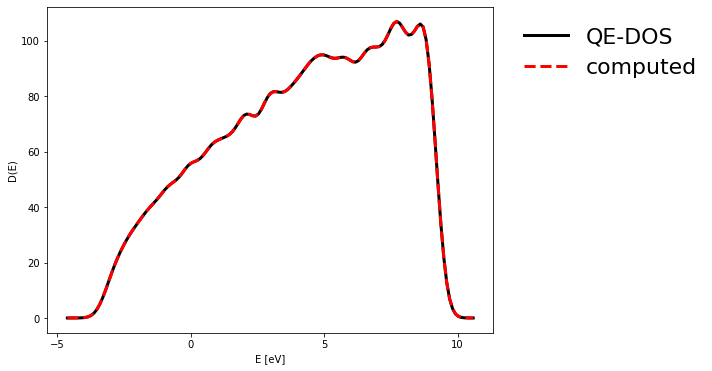

In [15]:
# Generate data
ra_en = dos_qe[: , 0]
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_qe*Ry2eV )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='--', linewidth=3, color='red',  label='computed')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

We recover the QE-DOS result by using the same parameters as in the input for computing the DOS.
Now we can go ahead and investigate different energy grids and smearing values in order to improve upon the band energy and achieve better agreement with the band-energy output of QE.

The "band energy" (or better, sum of eigenvalues) is defined as

$$E_{band} = \int_{-\infty}^{\infty} dE\ D(E)\, f(E)\, E$$

where $E$ denotes the energy, $D(E)$ the DOS, $f(E)$ the Fermi-Dirac distribution function.

The "band energy" is also called the "single-particle energy" or the "one-electron energy" and is obtained from summing the eigenvalues

$$E_{band} = \sum_i \epsilon_i\ .$$

For look at the particular values for a given snapshot (data from ```blake.sandia.gov:/home/acangi/q-e_calcs/Al/datasets/vasp_econ_snapshots/298K/2.699g/170726180545.0/100Ry_k333```). QE prints the one-electron energy in the standard output, together with all the other energy contributions, e.g., 
```
The total energy is the sum of the following terms:                                                  


     one-electron contribution =     737.82754675 Ry
     hartree contribution      =       4.77073244 Ry
     xc contribution           =    -554.09988814 Ry
     ewald contribution        =   -1375.56724973 Ry
     smearing contrib. (-TS)   =      -0.02019845 Ry
```
However, what QE prints as the "one-electron contribution" is not the sum of the eigenvalues, but instead (see source code ```~/PW/src/electrons.f90``` lines 638-640)

$$\text{one-electron contribution} = \sum_i \epsilon_i - (E_h + E_{xc})$$

In order to correctly compare the band energy obtained from integrating the DOS with the QE output we need to add the hartree and exchange-correlation contributions to the one-electron contribution.

In [ ]:
737.82754675

The correct band energy from QE output is

In [148]:
eband_qe = 737.82754675+4.77073244-554.09988814
print(eband_qe)

188.49839105


In [11]:
# Generate band energy
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

smearing width 0.032 eV (0.002351955764783704 Ry)
Band energy 189.2858381982402 Ry)


In [12]:
# Generate band energy
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*0.79255
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

smearing width 0.0253616 eV (0.0018640425413793248 Ry)
Band energy 188.49840580365412 Ry)


In [96]:
ewidth = dos_qe[: , 0][1]-dos_qe[: , 0][0]
print(ewidth)

0.10999999999999943


In [108]:
10e-3/Ry2eV

0.0007349861764949075

In [110]:
ewidth*Ry2eV

0.14966267872489925

In [100]:
dos_qe[: , 0]

array([-4.6270e+00, -4.5170e+00, -4.4070e+00, -4.2970e+00, -4.1860e+00,
       -4.0760e+00, -3.9660e+00, -3.8560e+00, -3.7460e+00, -3.6350e+00,
       -3.5250e+00, -3.4150e+00, -3.3050e+00, -3.1940e+00, -3.0840e+00,
       -2.9740e+00, -2.8640e+00, -2.7530e+00, -2.6430e+00, -2.5330e+00,
       -2.4230e+00, -2.3120e+00, -2.2020e+00, -2.0920e+00, -1.9820e+00,
       -1.8720e+00, -1.7610e+00, -1.6510e+00, -1.5410e+00, -1.4310e+00,
       -1.3200e+00, -1.2100e+00, -1.1000e+00, -9.9000e-01, -8.7900e-01,
       -7.6900e-01, -6.5900e-01, -5.4900e-01, -4.3800e-01, -3.2800e-01,
       -2.1800e-01, -1.0800e-01,  2.0000e-03,  1.1300e-01,  2.2300e-01,
        3.3300e-01,  4.4300e-01,  5.5400e-01,  6.6400e-01,  7.7400e-01,
        8.8400e-01,  9.9500e-01,  1.1050e+00,  1.2150e+00,  1.3250e+00,
        1.4360e+00,  1.5460e+00,  1.6560e+00,  1.7660e+00,  1.8770e+00,
        1.9870e+00,  2.0970e+00,  2.2070e+00,  2.3170e+00,  2.4280e+00,
        2.5380e+00,  2.6480e+00,  2.7580e+00,  2.8690e+00,  2.97

In [84]:
#ewidth=dos_qe[: , 0][1]-dos_qe[: , 0][0]
ewidth = (dos_qe[: , 0][1]-dos_qe[: , 0][0])*0.5
print(ewidth)
ra_sigma = np.linspace(0.5*ewidth, 5*ewidth, 11)
ra_enum = np.zeros(len(ra_sigma))
ra_eband = np.zeros(len(ra_sigma))
ra_en = np.linspace(dos_qe[0, 0], dos_qe[-1, 0], int((dos_qe[-1, 0]-dos_qe[0, 0])/ewidth)) 
for i in range(len(ra_sigma)):
    print("i:", i)
    # Generate electron number 
    ra_enum[i] = gen_enum(k_weights_qe, ra_en, eigs_qe, sigma=ra_sigma[i])
    # Generate band energy
    ra_eband[i] = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=ra_sigma[i])
print(ra_en[1]-ra_en[0])
print(ra_enum)
print(ra_eband)

0.054999999999999716
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
0.05531636363636405
[769.07398317 767.98692378 767.96155254 767.90867842 767.8228868
 767.71367989 767.59308992 767.47075313 767.35353666 767.24596084
 767.15044248]
[191.13617148 190.77127712 190.74968657 190.70934831 190.647702
 190.57020954 190.48376024 190.39388149 190.30453521 190.21835441
 190.13677113]


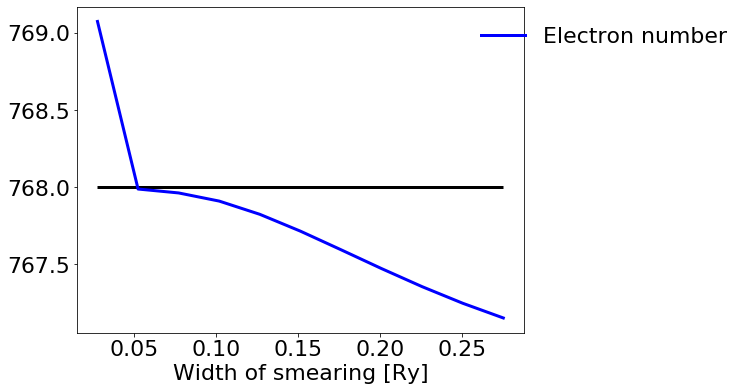

In [85]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of smearing [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

#ax.set_ylim(767.95, 768.05)

ax.hlines(enum_ref, ra_sigma[0], ra_sigma[-1], linewidth=3)
ax.plot(ra_sigma,  ra_enum, linestyle='-',  linewidth=3, color='blue', label='Electron number')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

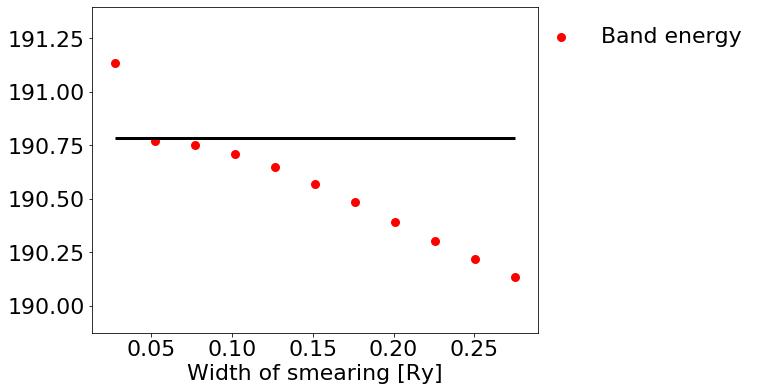

5.6447253206859394e-05


In [86]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of smearing [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})


ax.hlines(eband_ref/Ry2eV, ra_sigma[0], ra_sigma[-1], linewidth=3)
ax.scatter(ra_sigma,  ra_eband, linestyle='-',  linewidth=3, color='red', label='Band energy')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()
print(np.min(abs(ra_eband-eband_ref/Ry2eV))/256)

In [75]:
print(4*ra_sigma[0])

0.16622222222222136


In [87]:
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=ra_sigma[1] )

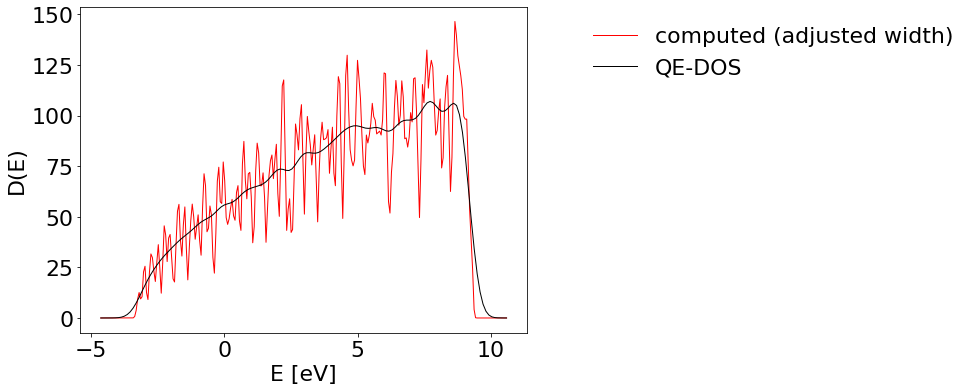

In [88]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=1, color='red',  label='computed (adjusted width)')
ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=1, color='black', label='QE-DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

In [ ]:
# Generate electron number 
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*0.79255
gen_enum(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )

Error in band energy compared to QE output

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

By adjusting the width of the Gaussian smearing we achieved the desired accuracy in the band energy, here < 1 meV.
The corresponding DOS looks like this:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

However, we can also increase the smearing width and also obtain an accurate band energy.

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]
emax = dos_qe[: , 0][-1]
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*29.177
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

The corresponding DOS looks like this:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

We can also generate a different energy grid. However, it the integral quickly converges with respect to the number of grid points. We can increase the range of the enegy grid to make sure the DOS decays to zero at the limits.

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]-1
emax = dos_qe[: , 0][-1]+1
# Decrease the number of energy grid points
ra_en = np.linspace(emin, emax, int(len(dos_qe[: , 0])))
sigma_mod = sigma_qe*29.908
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

The corresponding DOS looks like:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

Check for another snapshot.
The band energy from the QE output of snapshot 1 is:

In [51]:
eband_qe_01 = 739.08601067+4.18224128-553.98606038
print(eband_qe_01)

189.2821915699999


In [66]:
ewidth_01=dos_qe_01[: , 0][1]-dos_qe_01[: , 0][0]
print(ewidth_01)
emin = dos_qe_01[: , 0][0]-1
emax = dos_qe_01[: , 0][-1]+1
ra_en_01 = np.linspace(emin, emax, int(len(dos_qe_01[: , 0])))
ra_sigma_01 = np.linspace(20*ewidth_01, ewidth_01, 101)
ra_enum_01 = np.zeros(len(ra_sigma_01))
ra_eband_01 = np.zeros(len(ra_sigma_01))
for i in range(len(ra_sigma)):
    ra_en_01 = dos_qe[: , 0]
    # Generate electron number 
    ra_enum_01[i] = gen_enum(k_weights_qe_01, ra_en_01, eigs_qe_01, sigma=ra_sigma_01[i])
    # Generate band energy
    ra_eband_01[i] = gen_eband(k_weights_qe_01, ra_en_01, eigs_qe_01, sigma=ra_sigma_01[i])
print(ra_enum_01)
print(ra_eband_01)

0.11000000000000032
[760.49908813 760.8287977  761.31147628 761.84802112 762.38184006
 762.88243346 763.33481013 763.73317302 764.07731677 764.37052851
 764.61823564 764.82701935 765.00384572 765.1554767  765.28805498
 765.40685383 765.51616967 765.61932532 765.71874934 765.81609924
 765.91240276 766.00819853 766.10366451 766.19872772 766.29315348
 766.38661448 766.47874203 766.56916234 766.6575207  766.74349655
 766.82681167 766.9072337  766.98457624 767.05869702 767.12949467
 767.19690499 767.26089688 767.32146826 767.37864228 767.43246365
 767.48299536 767.53031572 767.57451559 767.61569608 767.65396636
 767.68944179 767.72224224 767.75249066 767.78031175 767.80583081
 767.82917281 767.85046146 767.86981852 767.88736313 767.90321127
 767.91747533 767.93026373 767.94168062 767.95182563 767.96079378
 767.96867526 767.97555548 767.98151497 767.98662947 767.99096993
 767.99460266 767.99758941 767.99998751 768.00185005 768.00322604
 768.00416057 768.00469505 768.00486737 768.0047121  768

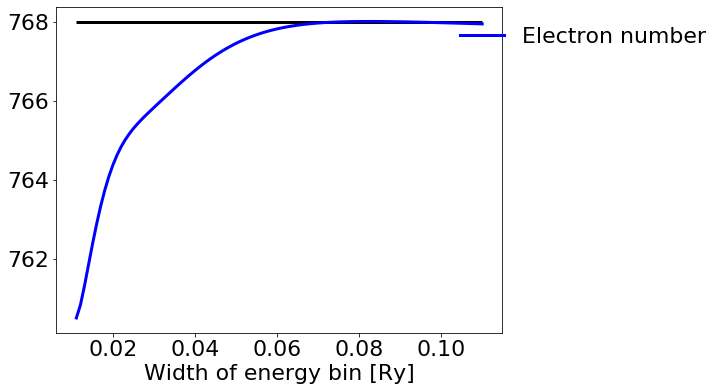

In [67]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of energy bin [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.hlines(768, ra_sigma_01[0], ra_sigma_01[-1], linewidth=3)
ax.plot(ra_sigma_01,  ra_enum_01, linestyle='-',  linewidth=3, color='blue', label='Electron number')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

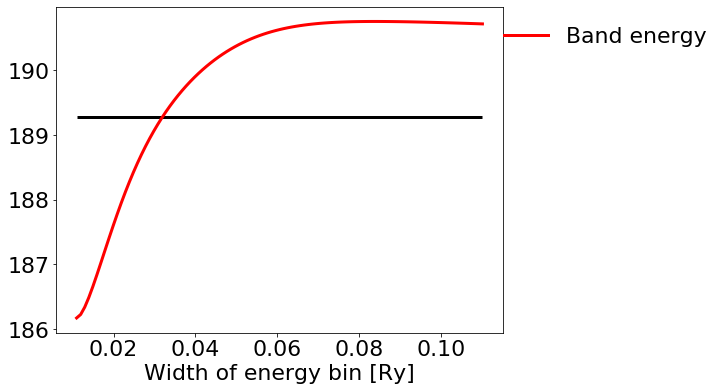

In [68]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of energy bin [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.hlines(eband_qe_01, ra_sigma_01[0], ra_sigma_01[-1], linewidth=3)
ax.plot(ra_sigma_01,  ra_eband_01, linestyle='-',  linewidth=3, color='red', label='Band energy')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Generate band energy
emin = dos_qe_01[: , 0][0]-1
emax = dos_qe_01[: , 0][-1]+1
# Decrease the number of energy grid points
ra_en = np.linspace(emin, emax, 2*int(len(dos_qe_01[: , 0])))
sigma_mod = sigma_qe*22.90#22.882
eband_01 = gen_eband(k_weights_qe_01, ra_en , eigs_qe_01, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband_01))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error_01 = eband_01-eband_qe_01
print("Error in Rydberg", eband_error_01)
print("Error in eV", eband_error_01*Ry2eV)

The corresponding DOS looks like:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe_01, ra_en, eigs_qe_01, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe_01[: , 0], dos_qe_01[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en           , ra_dos,           linestyle='-',  linewidth=3, color='red',   label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

This illustrates the issue with Gaussian smearing. The smearing width differs between the different snapshots. This means we cannot choose a fixed smearing width and obtain high accuracy in the band energy throughout a priori (i.e. without knowing the true value of the band energy). However, this might be fine, since we need to choose the smearing width only for the generation of training data. It might be somewhat inconvenient, but for each snapshot in the training data we can find the corresponding smearing width which will yield a band energy up to a target accuracy.

# Scratchpad

To do
* Perform search over smearing width using sp.optimize library. But this requires adapting the definitions of the functions above.
* Different representation of the $\delta$ function, for example Marzari-Vanderbilt (MV).

In [ ]:
# Define MV representation of delta function
def MV(en, mu, sigma):
    x = (mu-en)/sigma
    result = 1.0/np.sqrt(np.pi)*(2.0-np.sqrt(2)*x)*np.exp(-1.0*(x-(1.0/np.sqrt(2)))**2)
    return result

In [ ]:
# Sanity check of smearing functions
# Generate data
ra_en = np.linspace(7.,9.,601)
ra_gaussian = gaussian(ra_en, eF=fermi_energy, sigma=sigma_qe)
ra_MV = MV(ra_en, mu=fermi_energy, sigma=sigma_qe*2)
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(ra_en, ra_MV, linestyle='-',  linewidth=3, color='red', label='MV')
#ax.plot(ra_en, ra_gaussian, linestyle='-',  linewidth=3, color='blue', label='gaussian')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Function generating DOS from eigenvalues
def gen_DOS_ST(k_weights, array_en, array_eigs, sigma, smearing_type):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_en = array_en #dos_qe[: , 0]       # energy grid (same as QE-DOS input/output) 
    ra_dos_ik = [[] for i in range(dim_bnd)]
    ra_dos = np.zeros(len(array_en)) #create empty array
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            if (smearing_type == 1):
                smearing = gaussian(en=array_en, eF=array_eigs[idx_bnd , :][idx_k], sigma=sigma)
            elif (smearing_type == 2):
                smearing = MV(en=array_en, mu=array_eigs[idx_bnd , :][idx_k], sigma=sigma)
            else:
                print("Error, choose valid smearing function.")
            ra_dos_ik[idx_bnd].append(smearing)
            # Sum the Gaussians over idx_band and idx_k
            ra_dos += k_weights[idx_k]*ra_dos_ik[idx_bnd][idx_k]
    return ra_dos #, ra_dos_ik

In [ ]:
# Generate data
ra_en = dos_qe[: , 0]
ra_dos = gen_DOS_ST(k_weights_qe, ra_en, eigs_qe, sigma=sigma_qe*Ry2eV,smearing_type=2)

# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='--', linewidth=3, color='red',  label='computed')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband_ST(k_weights, array_en, array_eigs, sigma, smearing_type):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=fermi_energy, t=temp)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS_ST(k_weights_qe, array_en, eigs_qe, sigma, smearing_type)
    eband = sp.integrate.trapz(ra_dos*array_en*ra_fd, array_en)
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]-1
emax = dos_qe[: , 0][-1]+1
ra_en = np.linspace(emin, emax, int(len(dos_qe[: , 0])))
sigma_mod = sigma_qe*30.56825
eband = gen_eband_ST(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod, smearing_type=2)
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

In [ ]:
# Generate data
ra_dos = gen_DOS_ST(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod, smearing_type=2)
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()